# Simulate populations of neurons using NEST

In [1]:
from scipy.special import erf
import pylab
import numpy as np
import matplotlib.pyplot as plt
import nest

### Create populations

Each population is composed of 4,175 IAF neurons from which
80% are excitatory.

In [2]:
edict = {"I_e": 200.0, "tau_m": 20.0}
nest.CopyModel("iaf_psc_alpha", "exc_iaf_psc_alpha")
nest.SetDefaults("exc_iaf_psc_alpha", edict)

In [3]:
p1 = nest.Create("exc_iaf_psc_alpha", 4175)
p2 = nest.Create("exc_iaf_psc_alpha", 4175)
p3 = nest.Create("exc_iaf_psc_alpha", 4175)

In [4]:
# make 20% of the neurons inhibitory
for p in [p1,p2,p3]:
    for neuron in p[:835]:
        nest.SetStatus(neuron, {"I_e": 300.0})

In [5]:
# set random start Vs for all neurons
Vth=-55.
Vrest=-70.
for n1,n2,n3 in zip(p1,p2,p3):
    nest.SetStatus(n1, {"V_m": Vrest+(Vth-Vrest)*np.random.rand()})    
    nest.SetStatus(n2, {"V_m": Vrest+(Vth-Vrest)*np.random.rand()})
    nest.SetStatus(n3, {"V_m": Vrest+(Vth-Vrest)*np.random.rand()})    

## First case: Connect neurons only within populations

### Connect neurons

Each neuron receives a synapse from 10% of randomly selected cells inside its population.




In [6]:
for i, (n1,n2,n3) in enumerate(zip(p1,p2,p3)):
    
    # for each neuron randomize N / 10 ~ 417 neurons to connect to
    c1 = np.random.randint(0, 4175, 417)
    c2 = np.random.randint(0, 4175, 417)
    c3 = np.random.randint(0, 4175, 417)
        
    for idx1, idx2, idx3 in zip(c1,c2,c3):
        nest.Connect(p1[idx1], n1)        
        nest.Connect(p2[idx2], n2)
        nest.Connect(p3[idx3], n3)        

In [7]:
# TODO: add external poisson noise


### Simulate, measure and plot

In [8]:
# create a multimeter and a spike detector for each population
m1 = nest.Create("multimeter")
m2 = nest.Create("multimeter")
m3 = nest.Create("multimeter")

nest.SetStatus(m1, {"time_in_steps":True, "record_from":["V_m"]})
nest.SetStatus(m2, {"time_in_steps":True, "record_from":["V_m"]})
nest.SetStatus(m3, {"time_in_steps":True, "record_from":["V_m"]})

s1 = nest.Create("spike_detector")
s2 = nest.Create("spike_detector")
s3 = nest.Create("spike_detector")

In [9]:
# connect multimeters and spike detectors to the populations

nest.Connect(m1, p1)
nest.Connect(p1, s1)

nest.Connect(m2, p2)
nest.Connect(p2, s2)

nest.Connect(m3, p3)
nest.Connect(p3, s3)

In [10]:
nest.Simulate(100.0)

In [21]:
def plot_V():

    for idx, multimeter in enumerate([m1,m2,m3]):

        dmm = nest.GetStatus(multimeter)[0]
        Vms = dmm["events"]["V_m"]
        ts = dmm["events"]["times"]
        plt.rcParams["figure.figsize"] = (20,5)

        plt.plot(ts[np.arange(0,len(ts),4175)] / 10, Vms[np.arange(0,len(Vms),4175)])
        plt.title("population " + str(idx + 1))

        plt.show()

413325


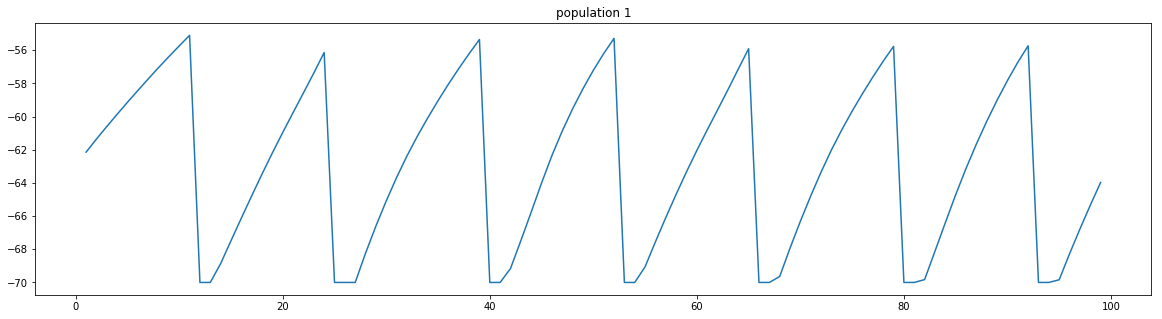

413325


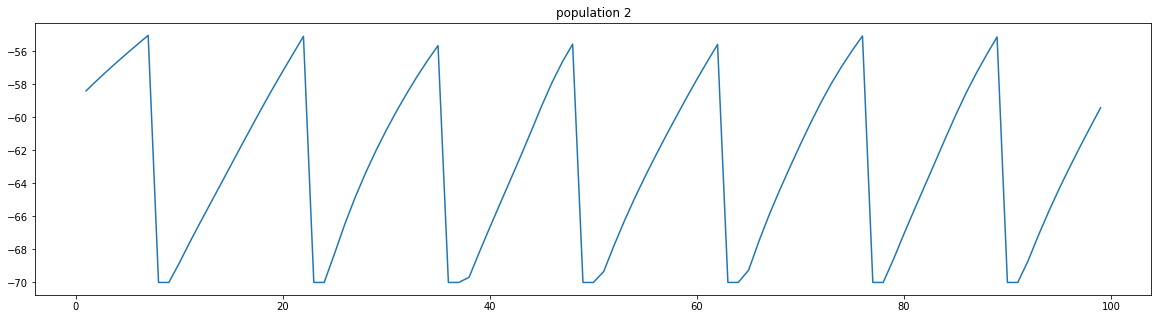

413325


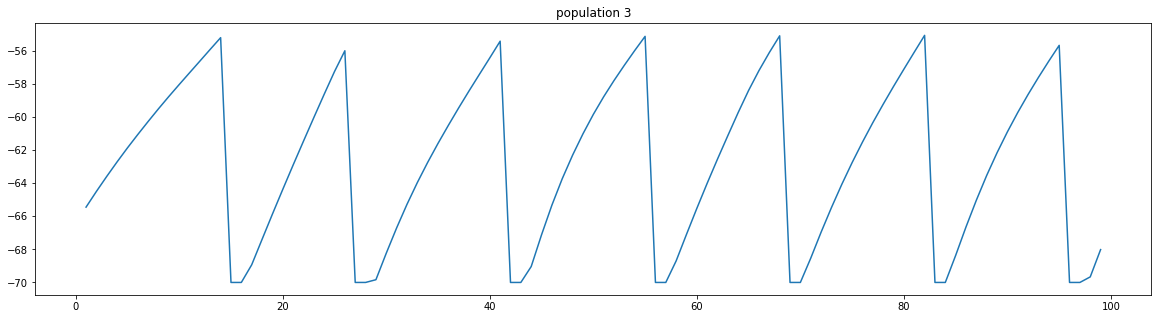

In [22]:
plot_V()

## Second case: Connect neurons to other populations

### Connect neurons

Each neuron also receives a synapse from 0.25% from the excitatory class of the neighboring populations.

In [23]:
for n1,n2,n3 in zip(p1, p2, p3):
    c1 = np.random.randint(835,4175,int(4175*0.0025))
    c2 = np.random.randint(835,4175,int(4175*0.0025))
    c3 = np.random.randint(835,4175,int(4175*0.0025))   
    #for idx in connections:
    #    nest.Connect(p2[idx], neuron, syn_spec = {"weight":20.0})
    for idx1, idx2, idx3 in zip(c1,c2, c3):
        nest.Connect(p2[idx1], n1) # p1 gets input from p2
        nest.Connect(p2[idx3], n3) # p3 gets input from p2
        nest.Connect([p1, p3][np.random.choice([0,1])][idx2], neuron) # p2 gets input from p1 & p3 (choose randomly)

In [24]:
nest.Simulate(100.0)

830825


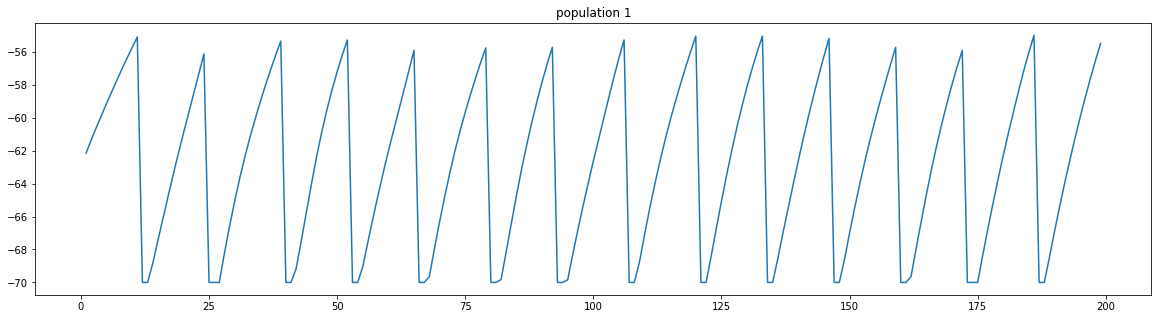

830825


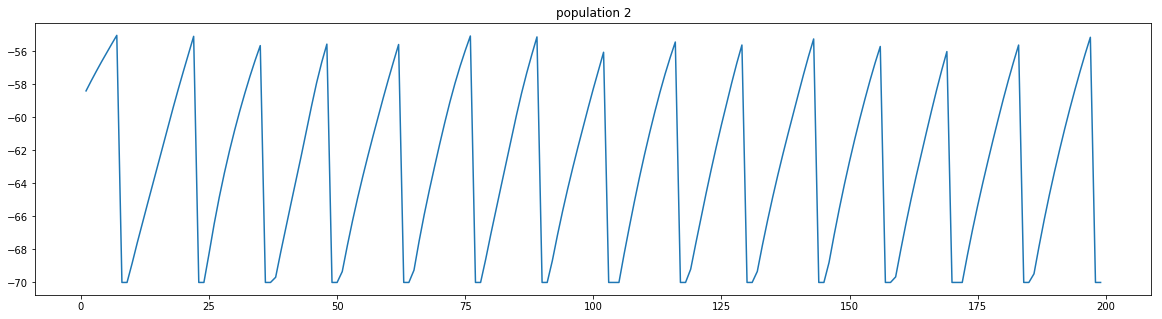

830825


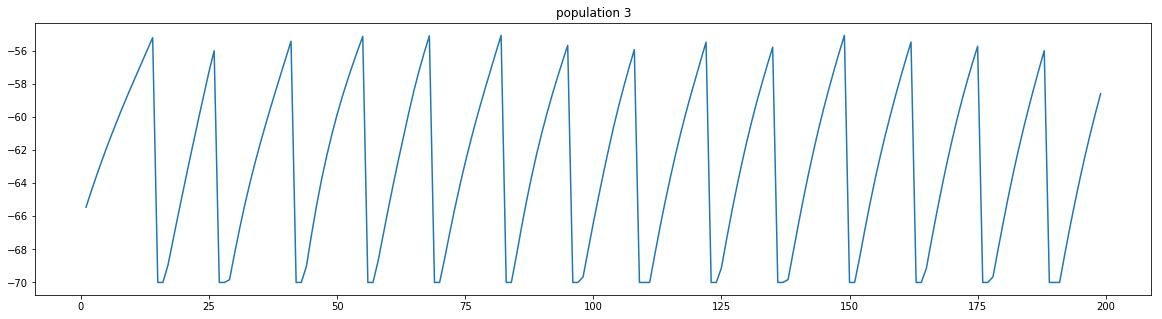

In [25]:
plot_V()